# How To Use Stackix

Stackix is our implementation of a stacked/hierarchical autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is less extensive because  
our pipeline works similarly for different architectures. Here, we focus only on Stackix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Stackix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` tutorial first.

## Stackix Theory

In our implementation, we train one variational autoencoder (VAE) per data modality end-to-end.  
The latent spaces of these *outer* autoencoders are then concatenated and used as input to another *inner* autoencoder.  
Downstream visualization and evaluation are performed on this **meta-latent space**, which represents a joint embedding of all modalities.  

For unpaired data, each outer autoencoder is trained on all available samples of its modality, even if the corresponding sample is missing in other modalities.  
When constructing the input for the inner autoencoder, non-overlapping samples are dropped to ensure consistency across modalities.  

This approach has two main goals:  
1. To produce more informative latent spaces for each modality.  
2. To provide a richer, joint representation for the inner autoencoder.  

We also store the dropped samples and their indices. This allows us to reconstruct the full dataset: the output of the inner autoencoder can be passed back through the outer autoencoders, where decoding recovers the original modalities.  

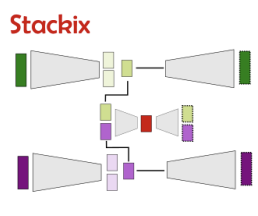

## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run it. <br><br>
2. Understand the Stackix-specific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access the Stackix-specific **results** (sub-results for "outer" autoencoders). <br><br>
4. **Visualize** outputs. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

Let’s get started! 🚀


## 1) Initialize and Run Stackix

We set a few custom parameters of the config file. For a deep dive into the config object, see:  

`Tutorials/DeepDives/ConfigTutorial.ipynb`

#### 1.1 The Dataset

We provide a mock dataset of sequencing data, including proteomics and RNA-seq.  
The dataset is accompanied by annotation data containing metadata such as batch, condition, and quality score.


In [1]:
import autoencodix as acx
from autoencodix.configs.default_config import DataCase
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK

# Stackix has its own config class
# instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly.
# this time with single cell data
print("Input data:")
print(EXAMPLE_MULTI_BULK)
print("-" * 50)
my_config = StackixConfig(
    epochs=27,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_BULK,
)
print("\n")
print("Starting Pipeline")
print("-" * 50)
print("-" * 50)
stackix = acx.Stackix(data=EXAMPLE_MULTI_BULK, config=my_config)
result = stackix.run()

Input data:
multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
--------------------------------------------------


Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 15.2032
Sub-losses: recon_loss: 15.2032, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 11.2017
Sub-losses: recon_loss: 11.2017, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 14.6425
Sub-losses: recon_loss: 14.6424, var_loss: 0.0000, anneal_factor: 0.0001, effective_be

## 2) Stackix-Specific Steps

Stackix does not introduce additional steps to the overall pipeline. However, its preprocessing and training differ slightly from Varix and Vanillix.  
Stackix processes each data modality individually and thus supports unpaired data input.  

This is enabled by setting the config parameter `requires_paired=False`.  
In the following example, we build unpaired data by dropping some samples from our raw_rna data. The outer autoencoder for the protein modality still trains on all protein samples, including those without corresponding RNA. These RNA samples are only excluded when concatenating the latent spaces for the inner autoencoder. Later, we can add these samples back to the inner AE output and feed them into the decoder of the outer protein autoencoder, allowing full reconstruction.

In [2]:
import pandas as pd

from autoencodix.data.datapackage import DataPackage
from autoencodix.utils.example_data import annotation, raw_protein, raw_rna
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

rna_anno: pd.DataFrame = annotation.drop(
    index=["sample_2", "sample_8", "sample_50", "sample_61"]
)
print(rna_anno.shape)
rna_unpaired: pd.DataFrame = raw_rna.drop(
    index=["sample_2", "sample_8", "sample_50", "sample_61"]
)
print(rna_unpaired.shape)
unpaired_dp: DataPackage = DataPackage(
    multi_bulk={"rna": rna_unpaired, "protein": raw_protein},
    annotation={"rna": rna_anno, "protein": annotation},
)
unpaired_config: StackixConfig = StackixConfig(
    data_case=DataCase.MULTI_BULK, requires_paired=False
)
unpaired_stackix: acx.Stackix = acx.Stackix(data=unpaired_dp, config=unpaired_config)
unpaired_result = unpaired_stackix.run()

(496, 3)
(496, 100)
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: rna
anno key: protein
Training each modality model...
Training modality: rna
Training modality: rna
Epoch 1 - Train Loss: 15.6369
Sub-losses: recon_loss: 15.6369, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 11.9511
Sub-losses: recon_loss: 11.9511, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 13.5448
Sub-losses: recon_loss: 13.5296, var_loss: 0.0152, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 12.5192
Sub-losses: recon_loss: 12.5129, var_loss: 0.0063, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 13.6501
Sub-losses: recon_loss: 13.2439, var_loss: 0.4063, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 11.8456
Sub-losses: recon_loss: 11.6366, var_loss: 0.2091, anneal_factor: 0.9656, effecti

## 3) Access Stackix-Specific Outputs

As explained above, we train *outer* autoencoders for each data modality and one shared *inner* autoencoder.  
The results (losses, reconstructions, latent spaces, etc.) for the *inner* autoencoder can be accessed in the same way as for the Vanillix autoencoder (see [1] and [2]).  
The results for the *outer* autoencoders are stored in a special `sub_results` structure, as illustrated in the Python code below.  

The `sub_results` can be accessed as an attribute of the `result` object.  
On the first level, this is a `Dict` with keys corresponding to the data modalities (as defined in Step 1).  
The value for each key is a `result` object analogous to the general result object.  
These can be accessed via our standard API (see also [2]).

[1] `Tutorials/PipelineTutorials/Vanillix.ipynb`  
[2] `Tutorials/DeepDives/PipelineOutputTutorial.ipynb`


In [3]:
outer_result = result.sub_results
print(outer_result.keys())

dict_keys(['transcriptomics', 'proteomics'])


In [4]:
print(outer_result["proteomics"])
# access latent space of outer proteomics autoencoder
outer_result["proteomics"].latentspaces.get(split="test", epoch=-1)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 0 × 0
final_reconstruction: None
sub_results: None
sub_reconstructions: None
embedding_evaluation: Empty DataFrame
Columns: []
Index: []


array([[-0.26699403,  0.9184728 ,  1.2672164 , ..., -0.58728313,
        -0.07182303,  1.1162832 ],
       [ 0.0034461 , -1.7727289 , -0.7503553 , ...,  0.6493522 ,
        -1.2804453 ,  1.7419057 ],
       [ 0.6252915 ,  1.2825012 ,  0.42250025, ..., -0.65801626,
         0.6544304 ,  0.31942457],
       ...,
       [ 0.41988802, -0.37745878, -0.37387994, ..., -0.6869261 ,
         0.49124092,  0.18293215],
       [-0.6865423 , -2.0755646 , -0.889151  , ...,  2.4635885 ,
        -1.113227  ,  1.6745024 ],
       [ 0.01192091, -1.0133258 ,  1.568099  , ...,  1.2381471 ,
         1.0866283 ,  0.3327515 ]], shape=(100, 16), dtype=float32)

In [5]:
# the inner result can be accessed directly
result.latentspaces.get(split="test", epoch=-1)
# or as dataframe with ids
result.get_latent_df(split="test", epoch=-1)

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,LatDim_8,LatDim_9,LatDim_10,LatDim_11,LatDim_12,LatDim_13,LatDim_14,LatDim_15
sample_1,0.663235,0.554585,0.537384,-0.933373,-0.335514,-0.963850,-0.479628,-0.469953,-1.571172,-0.216715,0.171644,0.475877,2.836747,1.585912,-0.169813,1.003859
sample_114,0.374872,-1.062482,0.129830,1.280451,-1.310234,-0.092898,1.284439,0.977147,1.079953,-0.515078,-0.462055,0.123734,1.168136,-1.405470,0.520965,0.292196
sample_119,-2.060784,-0.089548,0.871649,-0.391617,-0.932261,1.470614,0.415476,1.718104,-0.908985,1.474066,0.105918,1.761909,0.770961,-1.466445,-0.954872,-0.194490
sample_123,2.561783,-0.919952,2.219009,-0.393280,-0.635733,-1.730423,-2.506607,0.606500,0.156603,-0.709526,-1.209109,-0.613008,1.897382,-1.948386,-0.557508,-2.394033
sample_131,-0.114552,-0.767790,-0.326643,0.256499,0.163476,0.302378,0.131388,-0.015037,1.035415,-0.102422,3.174692,0.214011,1.419398,1.018995,0.822948,1.302579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_84,-0.390029,1.150114,0.055716,1.415391,-0.887767,-0.336262,-0.971629,-0.371725,-0.009209,-0.766185,-0.105540,0.279883,1.031121,0.289498,1.083549,-0.454669
sample_87,0.890972,-1.323562,-0.152012,-0.402627,0.252200,1.442705,-2.487726,0.227482,-2.200022,0.332061,-0.400975,-0.807901,0.692453,-0.234957,1.560332,0.832629
sample_93,1.287723,-0.487018,-1.588423,0.959962,0.302219,0.602498,1.471637,-0.261841,0.921054,1.095528,1.585932,0.083392,0.248956,-0.752551,1.607308,-0.754997
sample_95,0.745273,0.931545,-2.010942,1.623338,1.180857,-0.007478,1.635597,-1.386904,0.913773,-2.154805,-0.382251,-0.340487,0.613240,-1.469831,-0.098561,-1.075511


## 4) Visualize Outputs

This works exactly as for our other pipelines, by calling the `show_result` method.  
For more information, see our Visualization Deep Dive.  

We can pass a column from the annotation file using the keyword argument `params` to color the plots according to this column.

[3] `Tutorials/DeepDives/VisualizeTutorial.ipynb`


Creating plots ...


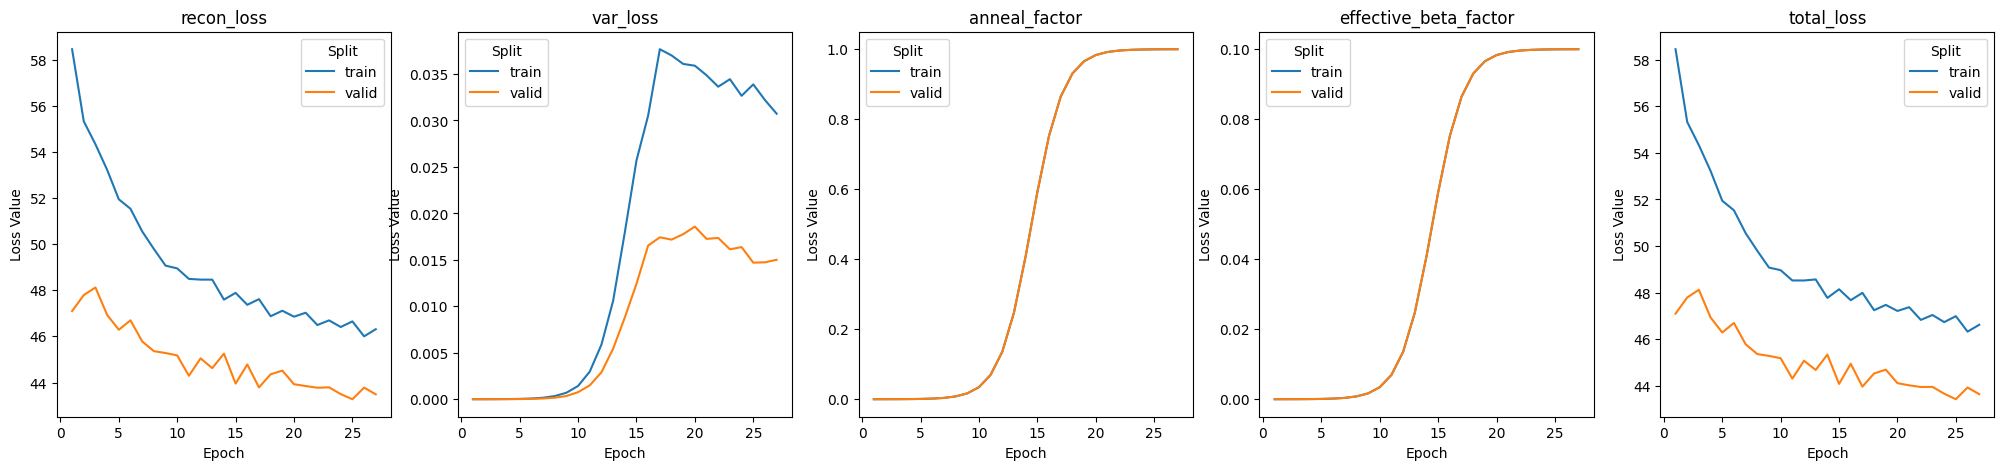

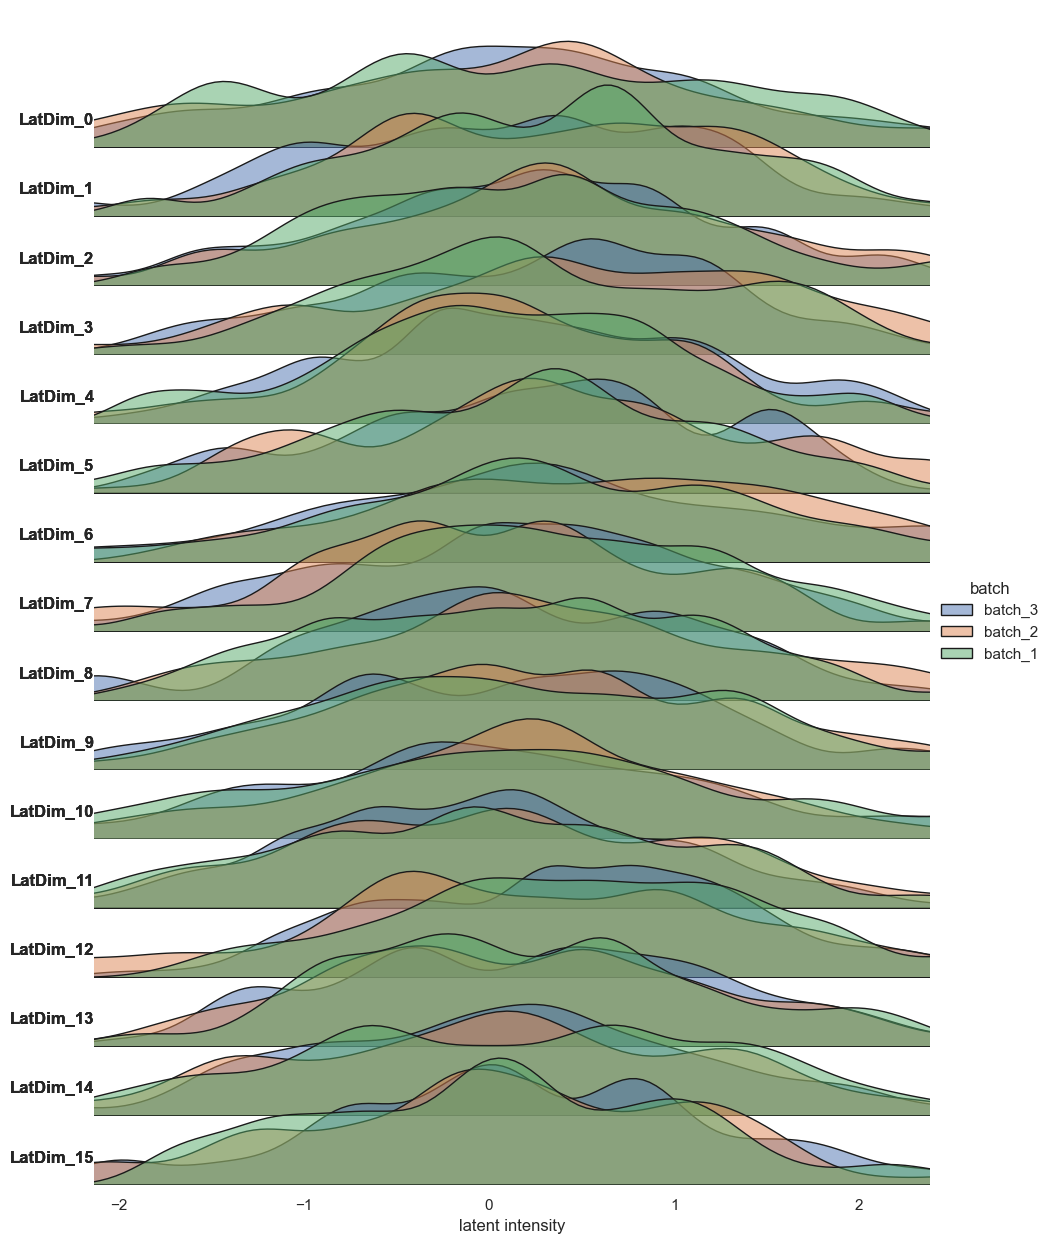

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


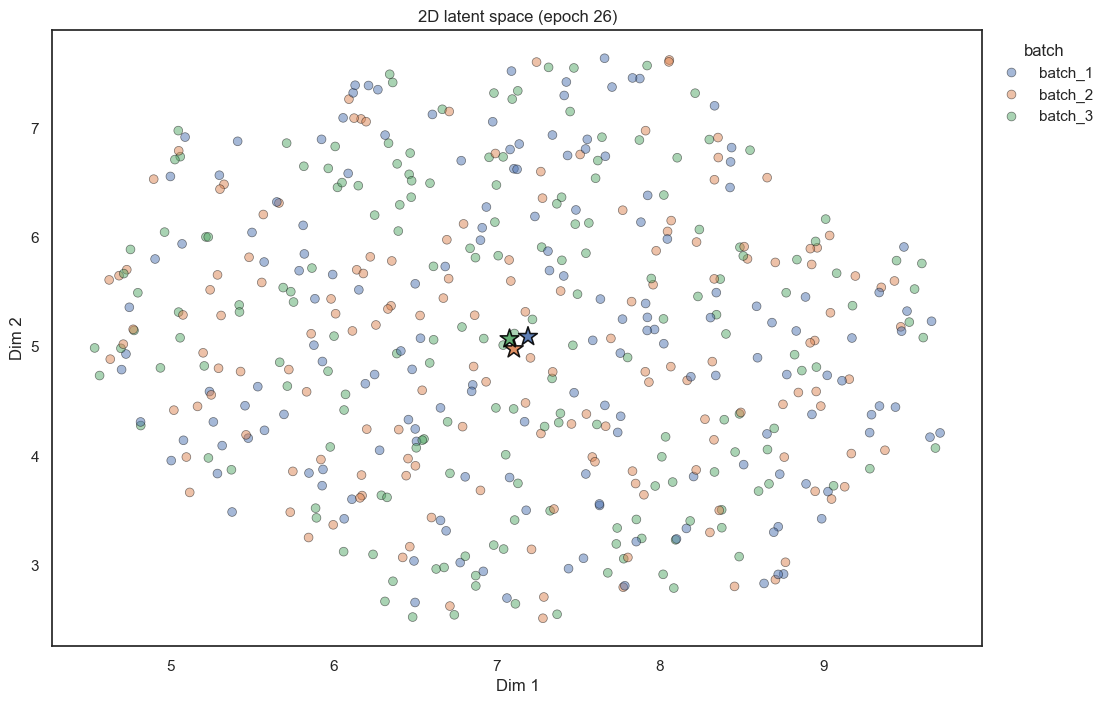

In [6]:
stackix.show_result(params=["batch"])

## 5) Customize Stackix Parameters

Since Stackix is composed of variational autoencoders, there are no Stackix-specific customizations that were not already shown in the `Varix` tutorial.  

However, it is possible to change the architecture to a vanilla autoencoder via the `model_type` attribute when initializing Stackix.  
Please note that this attribute expects a **class type**, not an instance of the class.  
Therefore, you need to import the appropriate `Architecture` (see [API reference](https://maxjoas.github.io/autoencodix_package/api/modeling)) and the corresponding loss type (e.g., `VanillixLoss` if using a vanilla autoencoder).  

See the code below for a clearer example.


In [7]:
import autoencodix as acx
from autoencodix.configs.default_config import DataCase
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK
from autoencodix.modeling import VanillixArchitecture
from autoencodix.utils import VanillixLoss

my_config = StackixConfig(
    epochs=27,
    checkpoint_interval=5,
    data_case=DataCase.MULTI_BULK,
)
stackix = acx.Stackix(
    data=EXAMPLE_MULTI_BULK,
    config=my_config,
    model_type=VanillixArchitecture,
    loss_type=VanillixLoss,
)
result = stackix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 15.9756
Sub-losses: recon_loss: 15.9756
Epoch 1 - Valid Loss: 9.3785
Sub-losses: recon_loss: 9.3785
Epoch 2 - Train Loss: 14.4331
Sub-losses: recon_loss: 14.4331
Epoch 2 - Valid Loss: 9.2388
Sub-losses: recon_loss: 9.2388
Epoch 3 - Train Loss: 12.7456
Sub-losses: recon_loss: 12.7456
Epoch 3 - Valid Loss: 9.0928
Sub-losses: recon_loss: 9.0928
Epoch 4 - Train Loss: 12.0679
Sub-losses: recon_loss: 12.0679
Epoch 4 - Valid Loss: 8.8835
Sub-losses: recon_loss: 8.8835
Epoch 5 - Train Loss: 11.2524
Sub-losses: recon_loss: 11.2524
Epoch 5 - Valid Loss: 8.6167
Sub-losses: recon_loss: 8.6167
Epoch 6 - Train Loss: 10.6543
Sub-losses: recon_loss: 10.6543
Epoch 6 - Valid Loss: 8.3966
Sub-losses: recon_loss: 8.3966
Epoch 7 - Train Loss: 10.9083


## 6) Saving, Loading and Reusing
This works for `Stackix` as for any other models, by using the `save` and `load` methods.

In [11]:
import os
import glob

outpath = os.path.join("tutorial_res", "stackix")
stackix.save(file_path=outpath, save_all=False)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# The load functionality will automatically rebuild the pipeline object
# from the saved files.
stackix_loaded = acx.Stackix.load(outpath)


Preprocessor saved successfully.
saving memory efficient
Pipeline object saved successfully.
PKL files: ['tutorial_res/disent.pkl.pkl', 'tutorial_res/van_preprocessor.pkl', 'tutorial_res/stackix.pkl_preprocessor.pkl', 'tutorial_res/varix.pkl_preprocessor.pkl', 'tutorial_res/varix.pkl', 'tutorial_res/van.pkl.pkl', 'tutorial_res/disent.pkl_preprocessor.pkl', 'tutorial_res/van.pkl_preprocessor.pkl', 'tutorial_res/van.pkl', 'tutorial_res/varix.pkl.pkl', 'tutorial_res/stackix.pkl.pkl', 'tutorial_res/varix_preprocessor.pkl']
Model files: ['tutorial_res/disent.pkl_model.pth', 'tutorial_res/stackix.pkl_model.pth', 'tutorial_res/varix_model.pth', 'tutorial_res/van_model.pth', 'tutorial_res/varix.pkl_model.pth', 'tutorial_res/van.pkl_model.pth']
Attempting to load a pipeline from tutorial_res/stackix.pkl...
Pipeline object loaded successfully. Actual type: Stackix
Preprocessor loaded successfully.


In [12]:
stackix_loaded.predict(data=EXAMPLE_MULTI_BULK)

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
Found 500 common samples for the stacked autoencoder.
Successfully created annotated latent space object (adata_latent).


Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={})
preprocessed_data: Tensor of shape (0,)
model: VanillixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x14dc09880>, valid=None, test=<autoencodix.data._multimodal_dataset.MultiModalDataset object at 0x14dbb69c0>)
adata_latent: AnnData object with n_obs × n_vars = 500 × 16
final_reconstruction: multi_bulk:
  transcriptomics: 500 samples × 10 features
  proteomics: 500 samples × 10 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
sub_results: None
sub_reconstr

In [10]:
stackix_loaded.show_result(params=["batch"])

Creating plots ...
Absolute loss plot not found in the plots dictionary
This happens, when you did not run visualize() or if you saved and loaded the model with `save_all=False`


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(


ValueError: Length of values (128000) does not match length of index (8000)